In [1]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Dataset paths
base_dir = 'augmented_split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Constants
IMG_SIZE = 256
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
val_gen = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = train_gen.num_classes

# Build CNN model
def build_cnn_model(lr=1e-4, dense_units=128, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Fitness function for PSO
def fitness_function(params):
    lr, dense_units, dropout_rate = params
    dense_units = int(dense_units)

    model = build_cnn_model(lr=lr, dense_units=dense_units, dropout_rate=dropout_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[early_stop], verbose=0)
    _, val_acc = model.evaluate(val_gen, verbose=0)
    return -val_acc  # negative because we minimize in PSO

# Hybrid PSO Optimizer Class
class HybridPSO:
    def __init__(self, fitness_func, dim, bounds, population_size=6, iterations=5, w=0.7, c1=1.5, c2=1.5):
        self.fitness_func = fitness_func
        self.dim = dim
        self.bounds = bounds
        self.pop_size = population_size
        self.iterations = iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def initialize(self):
        pos = np.array([np.random.uniform(low, high, self.pop_size) for low, high in self.bounds]).T
        vel = np.zeros_like(pos)
        return pos, vel

    def optimize(self):
        pos, vel = self.initialize()
        fit = np.array([self.fitness_func(ind) for ind in pos])
        pbest = pos.copy()
        pbest_scores = fit.copy()
        gbest_idx = np.argmin(fit)
        gbest_pos = pos[gbest_idx].copy()
        gbest_score = fit[gbest_idx]

        for t in range(self.iterations):
            for i in range(self.pop_size):
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)
                vel[i] = (self.w * vel[i] +
                          self.c1 * r1 * (pbest[i] - pos[i]) +
                          self.c2 * r2 * (gbest_pos - pos[i]))
                pos[i] += vel[i]
                pos[i] = np.clip(pos[i], [b[0] for b in self.bounds], [b[1] for b in self.bounds])

                new_fit = self.fitness_func(pos[i])
                if new_fit < pbest_scores[i]:
                    pbest_scores[i] = new_fit
                    pbest[i] = pos[i].copy()
                    if new_fit < gbest_score:
                        gbest_score = new_fit
                        gbest_pos = pos[i].copy()
            print(f"Iteration {t+1}/{self.iterations} | Best Val Accuracy: {-gbest_score:.4f}")
        return gbest_pos, -gbest_score

# Define bounds for hyperparameters
bounds = [
    (1e-5, 1e-3),   # Learning rate
    (64, 512),      # Dense units
    (0.2, 0.5)      # Dropout rate
]

# Run Hybrid PSO
dim = 3
optimizer = HybridPSO(fitness_function, dim, bounds, population_size=6, iterations=5)
best_params, best_val_acc = optimizer.optimize()

# Display best parameters
print("\n✅ Best Parameters Found:")
print("Learning Rate:", best_params[0])
print("Dense Units:", int(best_params[1]))
print("Dropout Rate:", best_params[2])
print("Best Validation Accuracy:", best_val_acc)


Found 21421 images belonging to 10 classes.
Found 4586 images belonging to 10 classes.
Found 4602 images belonging to 10 classes.


2025-06-20 19:01:21.237233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-06-20 19:01:21.237283: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-20 19:01:21.237293: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-06-20 19:01:21.237319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-20 19:01:21.237332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/simarkalsi/Projects/leafClassification/leaf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class shoul

Iteration 1/5 | Best Val Accuracy: 0.9211
Iteration 2/5 | Best Val Accuracy: 0.9211
Iteration 3/5 | Best Val Accuracy: 0.9211
Iteration 4/5 | Best Val Accuracy: 0.9211
Iteration 5/5 | Best Val Accuracy: 0.9211

✅ Best Parameters Found:
Learning Rate: 0.00016443784801812168
Dense Units: 396
Dropout Rate: 0.38509440786648186
Best Validation Accuracy: 0.9210640788078308


Epoch 1/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 68s 98ms/step - accuracy: 0.5154 - loss: 1.4076 - val_accuracy: 0.7523 - val_loss: 0.7597 - learning_rate: 1.6444e-04
Epoch 2/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.7751 - loss: 0.6804 - val_accuracy: 0.7813 - val_loss: 0.5917 - learning_rate: 1.6444e-04
Epoch 3/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.8216 - loss: 0.5368 - val_accuracy: 0.7730 - val_loss: 0.6557 - learning_rate: 1.6444e-04
Epoch 4/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.8462 - loss: 0.4541 - val_accuracy: 0.7106 - val_loss: 0.8659 - learning_rate: 1.6444e-04
Epoch 5/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 65s 98ms/step - accuracy: 0.8738 - loss: 0.3851 - val_accuracy: 0.9119 - val_loss: 0.2831 - learning_rate: 8.2219e-05
Epoch 6/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 65s 97ms/step - accuracy: 0.8844 - loss: 0.3470 - val_accuracy: 0.9023 - val_loss: 0.2979 - learning_rate: 8.2219e-05
Epoch 7/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/ste

/Users/simarkalsi/Projects/leafClassification/leaf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9522 - loss: 0.1490

🎯 Final Test Accuracy after Hybrid PSO: 96.02%


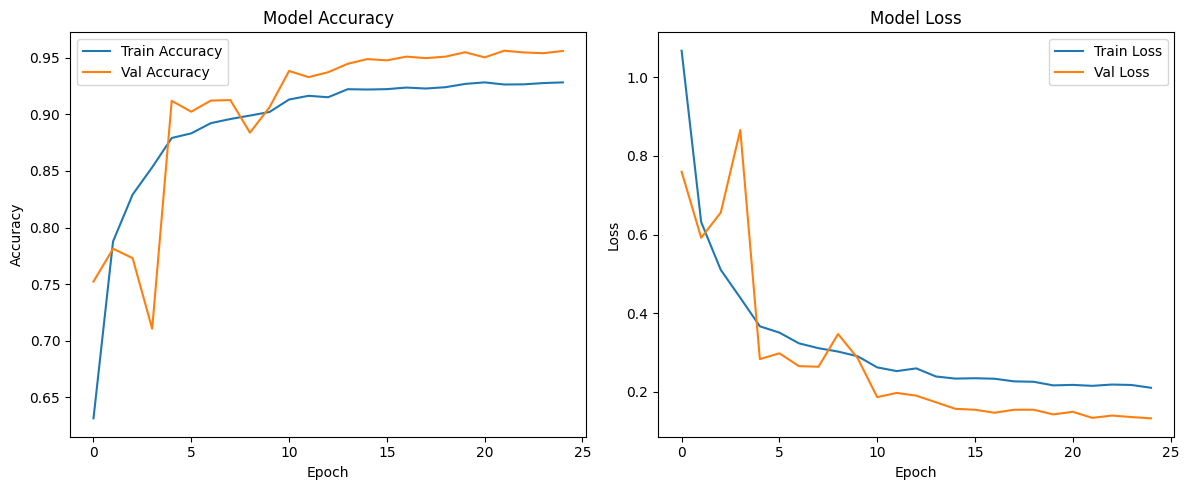

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

📊 Classification Report:

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.97      0.97      0.97       476
                        Tomato_Early_blight       0.94      0.93      0.94       445
                         Tomato_Late_blight       0.96      0.93      0.94       467
                           Tomato_Leaf_Mold       0.97      0.98      0.97       447
                  Tomato_Septoria_leaf_spot       0.95      0.95      0.95       468
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.94      0.94       467
                        Tomato__Target_Spot       0.93      0.94      0.93       461
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.98      0.98      0.98       482
                Tomato__Tomato_mosaic_virus       0.98      1.00      0.99       427
                             Tomato_healthy       0.99      0.99      0.99      

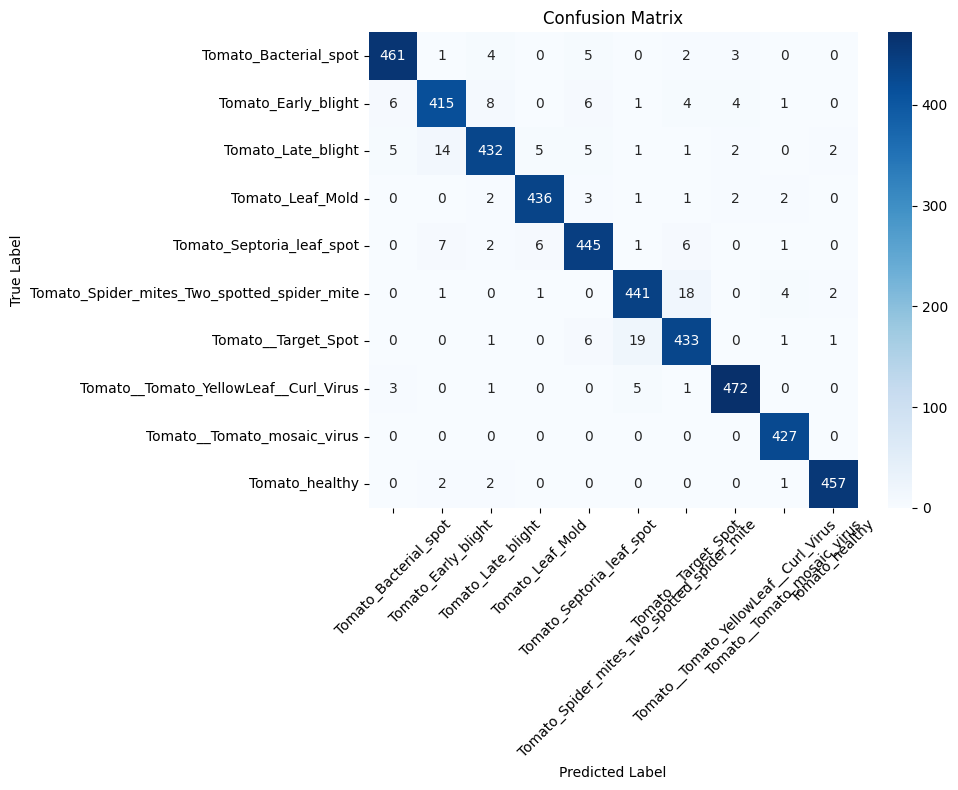

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Use best params from Hybrid PSO
best_lr = 0.00016443784801812168
best_dense = 396
best_dropout = 0.38509440786648186

# ✅ Build model
final_model = build_cnn_model(
    lr=best_lr,
    dense_units=best_dense,
    dropout_rate=best_dropout
)

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ✅ Train model
history = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ✅ Save model
final_model.save("cnn_hybrid_pso_final_model.keras")

# ✅ Evaluate on test data
test_loss, test_acc = final_model.evaluate(test_gen, verbose=1)
print(f"\n🎯 Final Test Accuracy after Hybrid PSO: {test_acc * 100:.2f}%")

# ✅ Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Classification report
y_true = test_gen.classes
y_pred = final_model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=class_labels))

# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
